# Text Generation using Recurrent NN

It is said that with enough training data, and computing resources, NNs can model any kind of output.

Generally, Recurrent NNs are used for making predictions (ex: intent classification, entity recognition etc.) however, I had not used RNNs in the setting of sequence generation.

Ideally, given enough data, RNNs can learn dependencies between characters/words and with that information, they can generate new sequences that closely resemble the input sequences.

#### Problem Statement - Model Dwight Jr. (from 'The Office')
Given all of Dwight Schrute's dialogs from the popular TV show - 'The Office', build a language model that is able to generate sentences that resembles the man, the myth, the legend himself - DWIGHT SCHRUTE

#### Approach:
- Identify datasets available which have all of Dwight's lines.
- Preprocess the text
    - Remove certain characters, lowercase etc. 
- Feature Engineer
- Build RNN aka. Dwight Jr.
    - Validate Dwight Jr.
    - Identify shortcomings from previous model
- Make changes to preprocessing pipeline -or- model architecutre
    - Rebuild model
    - Validate model
- Identify areas of improvement

In [1]:
from IPython.display import Image
Image(url='https://media.giphy.com/media/x37wEINncI98I/giphy.gif')  

In [4]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import re, sys
import numpy as np
from pathlib import Path
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils

- Found [link](http://officequotes.net/no1-01.php) to all of The Office dialogues.
- Wasn't useful as I manually had to scrape all seasons, all episodes
- Some angel on the internet scraped all the dialogues and created a [dataset](https://docs.google.com/spreadsheets/d/18wS5AAwOh8QO95RwHLS95POmSNKA2jjzdt0phrxeAE0/edit#gid=747974534) which was used for this project.

##### 1. Loading the data

In [5]:
# Load the data
###############
# steps:
# 1. doanload the dataset from the URL mentioned above (google sheets)
# 2. save it in the current working directory
###############
lines = pd.read_excel(r'the-office-lines.xlsx', encoding='utf-8')
# remove columns that are not wanted
lines.drop(['deleted', 'scene', 'season', 'episode', 'id'], axis=1, inplace=True)

##### 2. Preprocess the data

In [6]:
def preprocess(df):
    '''
    takes in a dataframe, and cleans the texts in the column 'line_text'
    :return: cleaned column
    '''
    s = df['line_text']
    try:
        s = s.lower()
        s = re.sub('�','',s)
        s = re.sub("[\(\[].*?[\)\]]", "", s)
        s = re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,]", "", s)
    except AttributeError:
        pass
    return s

In [7]:
# apply preprocessing method on the text
lines['clean_lines'] = lines.apply(preprocess, axis=1)

In [8]:
# get lines spoken by dwight
dwight = ["Andy and Dwight","Angela and Dwight", "Dwight", "Dwight ", "Dwight & Andy", "Dwight & Nate", "Dwight [on phone]", "Dwight and Andy", "Dwight and Angela", "Dwight and Erin", "Dwight and Michael", "Dwight and Roy", "Dwight, Erin, Jim & Kevin", "Dwight, Jim & Pam", "Dwight, Jim and Michael", "Dwight.", "Dwight:", "DwightKSchrute", "Jim & Dwight", "Jim and Dwight", "Jim, Josh, and Dwight", "Jim, Pam, Michael and Dwight", "Michael & Dwight", "Michael & Holly", "Michael and Dwight", "Michael/Dwight"]
dwight_lines = lines[lines['speaker'].isin(dwight)]

In [9]:
texts = '. '.join([str(x) for x in dwight_lines['clean_lines']])

In [10]:
# Model can't be fed pure text, 
# convert text to integers
# create a set of all distinct characters --> create a map of each char to a unique identifier. 
# in this case, an integer
chars = sorted(list(set(texts)))
char_to_int = dict((c, i) for i, c in enumerate(chars))
int_to_char = dict((i, c) for i, c in enumerate(chars))

In [11]:
n_chars = len(texts)
n_vocab = len(chars)
print ("Total Characters: ", n_chars)
print ("Total Vocab: ", n_vocab)

Total Characters:  438288
Total Vocab:  42


Notice, when combining all of Dwight's lines, we get ~ 400k characters. Even after lowercasing and removing some junk characters in the preprocessing, we end up with 42 as our vocab size, much more than the anticipated 26 (the letters of the english alphabet)

what are these extra characters?
should we have more pre-processing steps?

##### 3. Prepare data for training

A popular approach is to split texts into smaller chuncks (of any arbitarry length). Suppose the chunk size chosen is 10, here are some examples to show how chunking happens:
'assisstant general manager' --> 'assisstant', ' general m', ‘nager'
smaller length sequences as padded, larger length sequences are truncated
We split the texts into sequences of 100 characters, and convert the characters into ints using the dictionary we created with the mapping.


In [12]:
seq_len = 100
dat_X = []
dat_Y = []
for i in range(0, n_chars - seq_len, 1):
    seq_in = texts[i:i + seq_len]
    seq_out = texts[i + seq_len]
    dat_X.append([char_to_int[char] for char in seq_in])
    dat_Y.append(char_to_int[seq_out])
n_patterns = len(dat_X)

print ("Total Patterns: ", n_patterns)

Total Patterns:  438188


Now that we have made our first data transformation, we need to get it in the shape that an RNN expects i.e (samples, time_step, feats)

then, we rescale the ints from 0-1 for faster learning, and to prevent biases to larger or smaller numbers. It also helps with appliying the activation function (sigmoids)
Once we've done that, we need to transform the outputs into a one hot encoding. As we're trying to model the probability of the resulting character to occur, given that the past sequences are ___.
Hence, the obvious choice is to convert it to a one-hot so that the network can predict the probability of each of the 42 classes. We can also use categorical crossentropy


In [13]:
train_X = np.reshape(dat_X, (n_patterns, seq_len, 1))
# normalize
train_X = train_X / float(n_vocab)
# one hot encode the output variable
train_Y = np_utils.to_categorical(dat_Y)

- Now that all the data is prepared for ingestion by the LSTM, we define our model.
- For starters, lets choose a simple LSTM.
- Lets define an LSTM with 256 units
- Lets prevent overfitting (add some dropout)
- That's it !
- Now just a Dense to combine outputs from each LSTM unit, and a softmac activation to output a probability for each of the 42 classes (sum of all outputs must equal 1). Forcing the model to prefer some characters over the others. 
- Classical classification problem


##### 4. Train Model

In [14]:
# define the LSTM model
model_light = Sequential()
model_light.add(LSTM(256, input_shape=(train_X.shape[1], train_X.shape[2])))
model_light.add(Dropout(0.3))
model_light.add(Dense(train_Y.shape[1], activation='softmax'))
model_light.compile(loss='categorical_crossentropy', optimizer='adam')





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




Notice something peculiar?
- No validation set? Why?
- we don't have a lot of data, ~ 7.5k lines from Dwight isn't cutting it
- we are not interested in the most accurate model against a specifc training set. Not having a validation set, allows us to observe the generalization of the dataset which minimizes the loss function.
- the hard part in this case is a perfect balance between memorizing the training data, and generalizing so that the model won't overfit. (hence some dropouts being used)


### NETWORK TAKES SOME TIME TO TRAIN. GO GET COFFEE!

In [15]:
# define the checkpoint
import pathlib
directory = "model_weights/model_light/"
pathlib.Path(directory).mkdir(parents=True, exist_ok=True) 
filepath = directory + "weights-improvement-{epoch:02d}-{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [22]:
# fit the model
model_light.fit(train_X, train_Y, epochs=20, batch_size=128, callbacks=callbacks_list)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/20
438188/438188 [==============================] - 555s 1ms/step - loss: 2.7485

Epoch 00001: loss improved from inf to 2.74846, saving model to weights-improvement-01-2.7485.hdf5
Epoch 2/20
438188/438188 [==============================] - 560s 1ms/step - loss: 2.6061

Epoch 00002: loss improved from 2.74846 to 2.60609, saving model to weights-improvement-02-2.6061.hdf5
Epoch 3/20
438188/438188 [==============================] - 565s 1ms/step - loss: 2.5253

Epoch 00003: loss improved from 2.60609 to 2.52531, saving model to weights-improvement-03-2.5253.hdf5
Epoch 4/20
438188/438188 [==============================] - 568s 1ms/step - loss: 2.4557

Epoch 00004: loss improved from 2.52531 to 2.45572, saving model to weights-improvement-04-2.4557.hdf5
Epoch 5/20
438188/438188 [==============================] - 1759s 4ms/step - loss: 2.3970

Epoch 00005: loss improved from 2.45572 to 2.39

KeyboardInterrupt: 

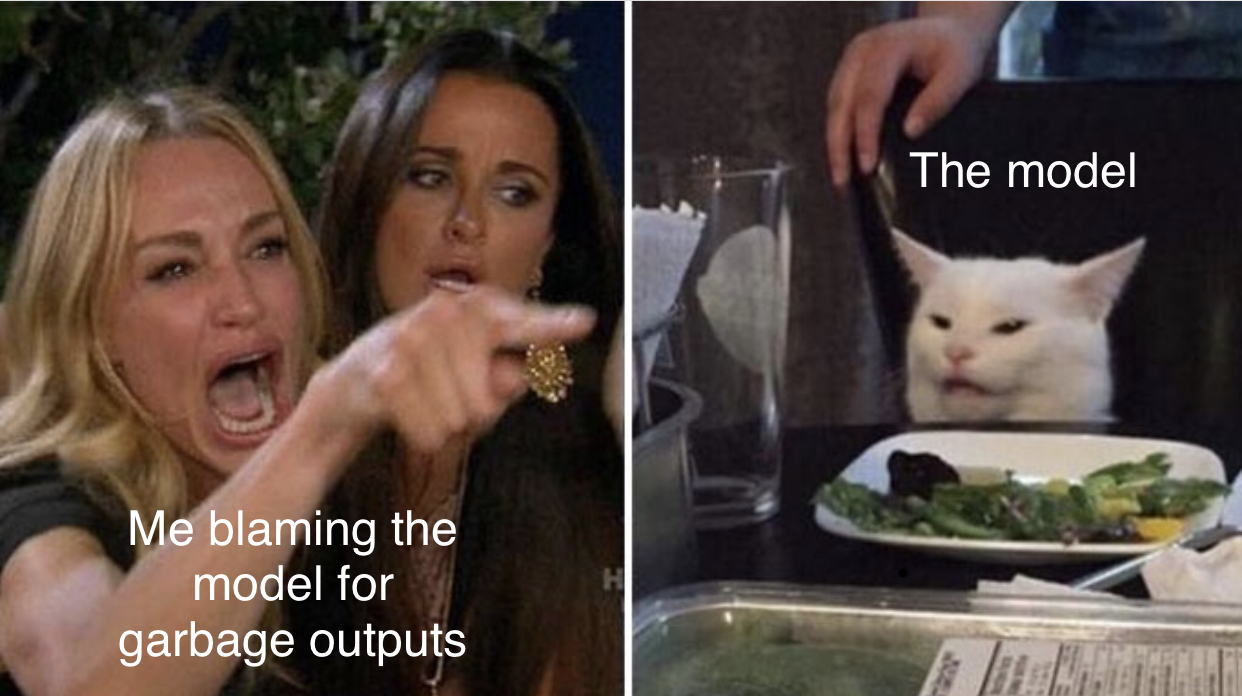

In [16]:
Image('meme.jpeg')

on completion, load the best model's weights below
PS: I stopped training at epoch 10. I got impatient, please train for at least 20 epochs.

In [17]:
# load the network weights
filename = "weights-improvement-09-2.2284.hdf5"
p = directory + filename
model_light.load_weights(Path(p))
model_light.compile(loss='categorical_crossentropy', optimizer='adam')

In [36]:
start = np.random.randint(0, len(dat_X)-1)
pattern = dat_X[start]
print ("Seed:")
print ("\"", ''.join([int_to_char[value] for value in pattern]), "\"")
pattern = dat_X[start]
print ("\nOutput:")
# generate characters
for i in range(100):
    x = np.reshape(pattern, (1, len(pattern), 1))
    x = x / float(n_vocab)
    prediction = model_light.predict(x, verbose=0)
    index = np.argmax(prediction)
    result = int_to_char[index]
    seq_in = [int_to_char[value] for value in pattern]
    sys.stdout.write(result)
    pattern.append(index)
    pattern = pattern[1:len(pattern)]
print ("\n\nDone.")

Seed:
" id identity theft happens all the time i can become you like that  but no one can become me. not tru "

Output:
e  io she care if he soeet toeet io a sear so the boe io the bart io the bart oo the boeek to the bo

Done.


Observations:
- smaller words are being properly formed
- some words make sense, but many don't
- considering the choice of using a character based model to produce text, the above lines are impressive!

How can we improve?
- more LSTM units
- more LSTM layers
- smaller batch size
- more epochs

In [38]:
model_heavy = Sequential()
model_heavy.add(LSTM(256, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
model_heavy.add(Dropout(0.3))
model_heavy.add(LSTM(256))
model_heavy.add(Dropout(0.3))
model_heavy.add(Dense(train_Y.shape[1], activation='softmax'))
model_heavy.compile(loss='categorical_crossentropy', optimizer='adam')

In [39]:
# define the checkpoint
directory_bigger = "model_weights/model_heavy/"
pathlib.Path(directory).mkdir(parents=True, exist_ok=True) 
filepath_bigger = directory + "weights-improvement-{epoch:02d}-{loss:.4f}-bigger.hdf5"
checkpoint = ModelCheckpoint(filepath_bigger, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [ ]:
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]
# fit the model
model_heavy.fit(train_X, train_Y, epochs=10, batch_size=64, callbacks=callbacks_list)

Epoch 1/10
438188/438188 [==============================] - 3077s 7ms/step - loss: 2.5419

Epoch 00001: loss improved from inf to 2.54193, saving model to weights-improvement-01-2.5419-bigger.hdf5
Epoch 2/10
438188/438188 [==============================] - 1660s 4ms/step - loss: 2.1950

Epoch 00002: loss improved from 2.54193 to 2.19497, saving model to weights-improvement-02-2.1950-bigger.hdf5
Epoch 3/10
438188/438188 [==============================] - 1757s 4ms/step - loss: 2.0489

Epoch 00003: loss improved from 2.19497 to 2.04894, saving model to weights-improvement-03-2.0489-bigger.hdf5
Epoch 4/10
339840/438188 [======================>.......] - ETA: 6:09 - loss: 1.9669

In [40]:
# load the network weights
filename_bigger = "weights-improvement-10-1.7418-bigger.hdf5"
model_heavy.load_weights(Path(directory_bigger +filename_bigger))
model_heavy.compile(loss='categorical_crossentropy', optimizer='adam')

In [53]:
start = np.random.randint(0, len(dat_X)-1)
pattern = dat_X[start]
print ("Seed:")
print ("\"", ''.join([int_to_char[value] for value in pattern]), "\"")
pattern = dat_X[start]
print ("\nOutput:")
# generate characters
for i in range(100):
    x = np.reshape(pattern, (1, len(pattern), 1))
    x = x / float(n_vocab)
    prediction = model_heavy.predict(x, verbose=0)
    index = np.argmax(prediction)
    result = int_to_char[index]
    seq_in = [int_to_char[value] for value in pattern]
    sys.stdout.write(result
    pattern.append(index)
    pattern = pattern[1:len(pattern)]
print ("\n\nDone.")

Seed:
" ect and frankly the fact that none of you are vomiting or diarrheal right now i find very alarming.  "

Output:
i meed to see you the perfect and i was a seat and i was a seat and i was a seat and i was a seat an

Done.


##### 5. Making sense of everything

###### 5.1 Problems associated with building a generative language model:
- Language is vague. English in particular is even more so. Why? homophones, homonyms, homographs, sarcasm, etc.
- It is challenging to model the specific meaning of a word in a sentence because of this nature. There is no formal definition that makes English definitive. As a result of which, the model is constantly working with a moving target (so to speak).
- Linguistics does help with formal structure and grammar, but spoken English is far from formal. (why would Urban Dictionary exsist otherwise?)

##### 5.2 Future Work

- Word Level Language Model:
    - tokenize texts, normalize them (lemmatize), instead of predicting the probabality of next character, predict the probability of next word
- Word Level Language Model (with embeddings):
    - apply same process as above using glove/fast-text/word2vec embeddings
- Sentence Level Language Model:
    - Use pre-trained language models (Bert, Elmo, XL-net) to get sentence level embeddings to predict next word/sentence.
- Reduce vocab size:
    - using all the words/characters isn't a good idea. not all words/characters are used equally likely. Skip words/characters based on a threshold. 
- Hyperparameter tuning:
    - use Bayesian Optimization techniques to identify the best set of network params for the model. Standard values used in industry may not apply to all sorts of techniques.
- Change network architecture:
    - dcombination of deeper + wider models have worked exceptionally well for NLP tasks. say tf-idf scores as one kind of input along with deeper models(more layers, more units etc) will require more resources and take longer time to train, but the outputs will be much more interesting.
    - try other RNNs (GRUs, Bi-LSTMs etc)
- one hot for input sequences
- lower batch size (longer training, but better chance for the network to learn
- create a fixed seq_len, but pad sentences instead of randomly chopping them